Обучить СНС с помощью Transfer Learning на датасете Food-101
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import time
import pandas as pd

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True, with_info=True, 
    split=['train[:90%]', 'train[90%:]']
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete9TEX12/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete9TEX12/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
class_names = ds_info.features['label'].names
class_names[:4]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio']

View

In [4]:
print(ds_info.features['image'])

Image(shape=(None, None, 3), dtype=tf.uint8)


In [5]:
print(ds_info.features['label'])

ClassLabel(shape=(), dtype=tf.int64, num_classes=101)


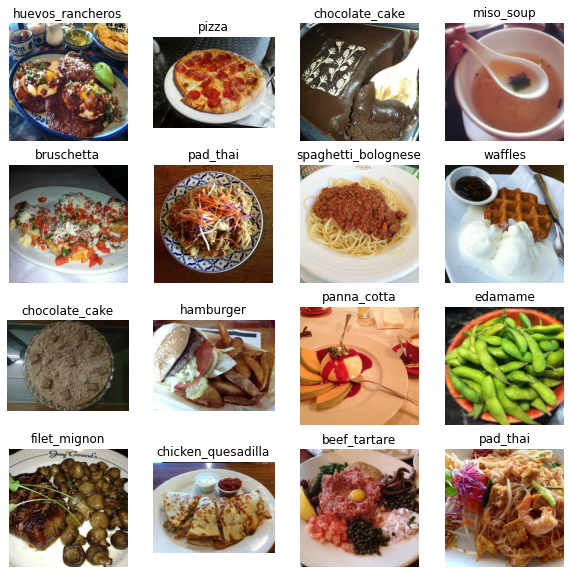

In [9]:
plt.figure(figsize=(10, 10))
for i, x in enumerate(train_ds.take(16)):
    plt.subplot(4, 4, i+1)
    plt.title(class_names[x[1].numpy()])
    plt.imshow(x[0])
    plt.axis('off')

Pipeline

In [10]:
SIZE = 160
BATCH_SIZE = 32

def augmentation(img, lbl):
    img = tf.cast(img, tf.float32) / 127 - 1
    img = tf.image.resize(img, (SIZE, SIZE))
    return img, lbl

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(augmentation)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(augmentation)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

Model + augmentation layers

In [11]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(SIZE, SIZE, 3),
    include_top=False,
    weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
base_model.trainable = True # Fine-tuning

In [13]:
model = tf.keras.Sequential([
    # augmentation
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.3),
    
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=101, activation='softmax')
])

In [14]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Checkpoint

In [15]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    model=model,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!')

Training

In [19]:
%%time
training = True

if training:
    history = model.fit(
        train_ds,
        epochs=5,
        validation_data=test_ds,
        verbose=0
    )
    ckpt_manager.save()

train_loss, train_accuracy = model.evaluate(train_ds.take(16))
test_loss, test_accuracy = model.evaluate(test_ds.take(16))

16/16 [==============================] - 3s 111ms/step - loss: 1.7984 - accuracy: 0.6035
CPU times: user 47min 33s, sys: 6min 37s, total: 54min 10s
Wall time: 40min 6s


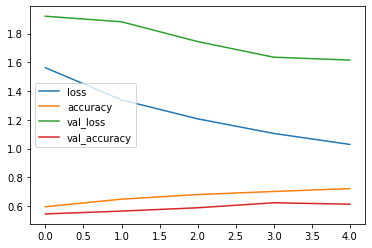

In [20]:
pd.DataFrame(history.history).plot()

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
print(f'train loss: {train_loss:.4f} | train accuracy: {train_accuracy:.3f}')
print(f'test loss: {test_loss:.4f} | test accuracy: {test_accuracy:.3f}')

train loss: 1.3047 | train accuracy: 0.658
test loss: 1.7984 | test accuracy: 0.604


View sample pred

In [23]:
img, lbl = next(iter(test_ds.take(1)))
pred_prob = model(img, training=False).numpy()
pred_perc = np.max(pred_prob, axis=1) * 100
pred_lbl = np.argmax(pred_prob, axis=1)
img = (img + 1) * 127
img = tf.cast(img, tf.int64)

true: risotto
pred: gnocchi
prob: 97.00%


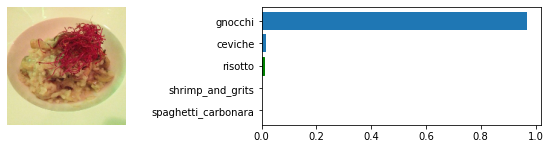

true: pizza
pred: pizza
prob: 98.67%


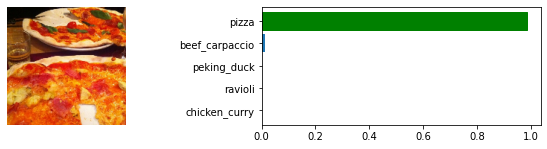

true: ravioli
pred: ravioli
prob: 34.99%


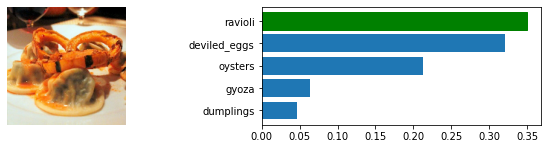

true: edamame
pred: edamame
prob: 100.00%


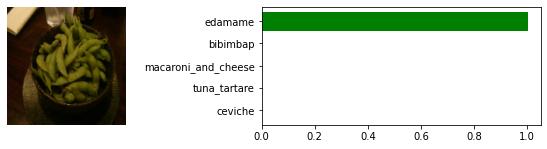

true: beef_tartare
pred: beef_tartare
prob: 70.49%


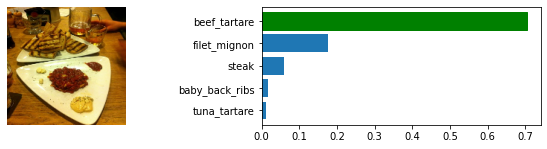

In [24]:
for i in range(5):
    true = class_names[lbl[i]]
    pred = class_names[pred_lbl[i]]
    print(f'true: {true}\n',
          f'pred: {pred}\n',
          f'prob: {pred_perc[i]:.2f}%', sep ='')
    
    plt.figure(figsize=(11, 10))
    
    # image
    plt.subplot(4, 2, 1)
    plt.imshow(img[i])
    plt.axis('off')
    
    # accuracy
    plt.subplot(4, 2, 2)
    food_prob = zip(class_names, pred_prob[i])
    food_prob = sorted(food_prob, key=lambda fp: fp[1])[-5:]
    
    food = np.array(food_prob)[:, 0]
    prob = np.array(food_prob)[:, 1].astype(np.float32)
    
    bars = plt.barh(food, prob)
    
    true_idx = np.where(food == true)[0]
    if true_idx.size:
        bars[true_idx[0]].set_color('g')

    plt.show()